In [1350]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### Specifying the paths

In [1351]:
csv_path = Path(
    r"\\wsl.localhost\Ubuntu-24.04\home\user\OF\attempt_2\results\csv\results.csv"
)
figures_path = Path(
    r"\\wsl.localhost\Ubuntu-24.04\home\user\OF\attempt_2\results/figures"
)
figures_path.mkdir(exist_ok=True, parents=True)

#### Loading in data

In [1352]:
df = pd.read_csv(csv_path, parse_dates=["datetime"])
df["cl_cd"] = df["cl"] / df["cd"]
df["cl_cd_abs"] = (df["cl"] / df["cd"]).abs()
df["failed"] = (~df[["block_mesh", "check_mesh", "simple"]]).any(axis=1)
df_filtered = df.dropna(subset=["cl", "cd"]).copy()
df_filtered["moving_avg"] = df_filtered["cl_cd_abs"].rolling(window=30).mean()

In [1353]:
df_filtered.sort_values(by="cl_cd_abs", ascending=False)

,datetime,UUID,run_name,x0,x1,x2,x3,x4,x5,block_mesh,check_mesh,simple,cl,cd,cl_cd,cl_cd_abs,failed,moving_avg
3002,2024-12-27 19:51:45.285383,1b72ef97-49bd-45f2-ba6d-e21ada5c6fe3,"Gathering data, including negative",-0.106041,0.193546,0.255316,0.106497,0.401822,0.237864,True,True,True,0.778206,0.019052,40.846549,40.846549,False,19.953381
3512,2024-12-27 21:23:38.096124,4f917c56-1822-496c-8914-bc3701cb52e5,"Gathering data, including negative",-0.132592,0.480979,0.343905,0.088433,0.416485,0.095356,True,True,True,0.814778,0.020229,40.278387,40.278387,False,18.817218
3428,2024-12-27 21:07:12.940226,666d0aee-ea56-45f3-b454-3cbdcd7b9faa,"Gathering data, including negative",-0.106616,0.174923,0.410194,0.048603,0.213742,0.388387,True,True,True,0.885826,0.022315,39.696824,39.696824,False,19.387072
2053,2024-12-27 17:27:58.647515,8f683299-1c37-46ce-a866-184c5dcf5b84,"Gathering data, including negative",-0.109434,0.355815,0.192206,0.154837,0.312089,0.232870,True,True,True,0.752132,0.019211,39.150882,39.150882,False,15.977273
3054,2024-12-27 20:02:06.300605,bff9f419-482d-43d1-bf46-085e829decc8,"Gathering data, including negative",-0.161898,0.203698,0.433854,0.236420,0.255209,0.411732,True,True,True,1.019665,0.026282,38.797602,38.797602,False,19.043644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,2024-12-27 12:40:02.722402,795eb143-b28e-42b6-88b0-971aad3cc4bb,"Gathering data, including negative",-0.934854,-0.293951,-0.490807,0.782206,0.665374,0.676146,True,True,True,-0.003560,0.048679,-0.073140,0.073140,False,7.363602
3039,2024-12-27 19:58:23.442500,72813859-1dcf-44c8-ac19-5adaaa2c9f56,"Gathering data, including negative",-0.155303,-0.494501,0.155544,0.244785,-0.046179,0.154805,True,True,True,-0.000568,0.016233,-0.034985,0.034985,False,18.004278
1011,2024-12-27 14:44:49.600176,367da24e-46e9-4ad2-b492-1a8f6b7afcb6,"Gathering data, including negative",-1.329876,-0.184246,-0.332697,0.849396,1.413174,1.373074,True,True,True,0.009214,0.265080,0.034759,0.034759,False,12.315959
843,2024-12-27 14:16:50.117282,fa0e6a9f-1927-4060-b189-071c64a179b3,"Gathering data, including negative",-0.589776,-0.738048,-0.707844,0.978766,0.474279,0.964287,True,True,True,-0.001104,0.051597,-0.021391,0.021391,False,9.995779


#### Progress plot

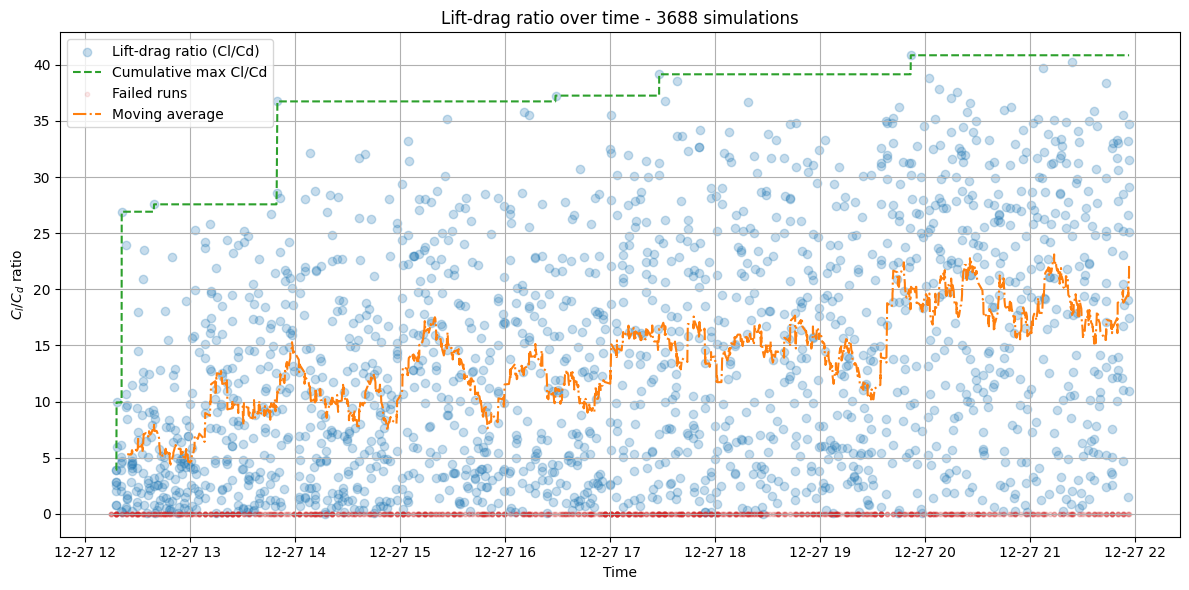

In [1354]:
plt.figure(figsize=(12, 6))
plt.scatter(
    df_filtered["datetime"],
    df_filtered["cl_cd_abs"],
    label="Lift-drag ratio (Cl/Cd)",
    marker="o",
    color="tab:blue",
    alpha=0.25,
)
plt.plot(
    df_filtered["datetime"],
    df_filtered["cl_cd_abs"].cummax(),
    label="Cumulative max Cl/Cd",
    linestyle="--",
    color="tab:green",
)
plt.scatter(
    df[df["failed"]]["datetime"],
    -df[df["failed"]]["failed"],
    s=10,
    color="tab:red",
    alpha=0.1,
    label="Failed runs",
)

plt.plot(
    df_filtered["datetime"],
    df_filtered["moving_avg"],
    label="Moving average",
    linestyle="-.",
    color="tab:orange",
)

plt.title(f"Lift-drag ratio over time - {len(df)} simulations")
plt.xlabel("Time")
plt.ylabel("$C_l/C_d$ ratio")

# Use a locator to reduce the density of x-ticks
# locator = mdates.HourLocator(interval=1)
# formatter = mdates.DateFormatter("%H:%M")
# plt.gca().xaxis.set_major_locator(locator)
# plt.gca().xaxis.set_major_formatter(formatter)

plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(
    "results/figures/27122024 - OpenFOAM - Lift-drag ratio over time.png", dpi=300
)
plt.show()

#### Attempts at model reduction

Mean Squared Error: 16.555199416266504
Mean Absolute Error: 2.8488468253223154
Mean Percentage Error: 22.60%

Dummy Model Evaluation:
Mean Squared Error (Dummy): 170.4827320482704
Mean Absolute Error (Dummy): 10.164446077430728
Mean Percentage Error (Dummy): 29.62%


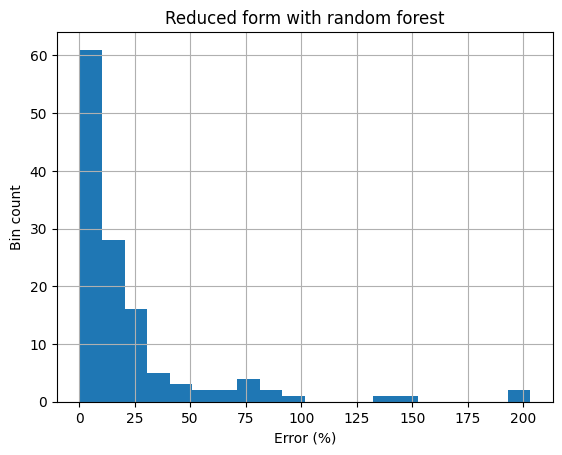

In [1364]:
df_subset = df_filtered[
    (df_filtered["cl_cd_abs"] > 5.0) & (df_filtered["cl_cd_abs"] < 35.0)
]

X = df_subset[["x0", "x1", "x2", "x3", "x4", "x5"]]
y = df_subset["cl_cd"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
percentage_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Percentage Error: {percentage_error:.2f}%")

# Dummy method: Mean baseline
y_dummy_pred = [y_train.mean()] * len(y_test)
mse_dummy = mean_squared_error(y_test, y_dummy_pred)
mae_dummy = mean_absolute_error(y_test, y_dummy_pred)
percentage_error_dummy = np.mean((y_test - y_dummy_pred) / y_test) * 100

print("\nDummy Model Evaluation:")
print(f"Mean Squared Error (Dummy): {mse_dummy}")
print(f"Mean Absolute Error (Dummy): {mae_dummy}")
print(f"Mean Percentage Error (Dummy): {percentage_error_dummy:.2f}%")

plt.hist(np.abs((y_test - y_pred) / y_test) * 100, bins=20)
plt.xlabel("Error (%)")
plt.ylabel("Bin count")
plt.title("Reduced form with random forest")
plt.grid()

plt.savefig(
    "results/figures/27122024 - OpenFOAM - random forest reduced form.png", dpi=300
)

In [1361]:
pd.set_option('display.max_rows', None)
pd.DataFrame({"pred": y_pred, "test": y_test.values})

,pred,test
0,17.326492,8.837245
1,13.482370,13.832320
2,7.433148,5.461259
3,11.179450,13.175503
4,3.677825,5.235764
5,31.417395,28.751144
6,31.538364,31.930967
7,-9.882415,-9.908574
8,27.361204,27.196517
9,25.077494,17.625997
